In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import scipy as scp
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
test.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [5]:
train['ACTION']

0        1
1        1
2        1
3        1
4        1
5        0
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
32739    1
32740    1
32741    1
32742    1
32743    1
32744    1
32745    1
32746    1
32747    1
32748    1
32749    1
32750    1
32751    1
32752    1
32753    1
32754    1
32755    1
32756    1
32757    1
32758    1
32759    1
32760    1
32761    1
32762    1
32763    1
32764    1
32765    1
32766    1
32767    1
32768    1
Name: ACTION, dtype: int64

In [6]:
from sklearn.linear_model import LogisticRegressionCV

In [7]:
Cs = [0.0005, 0.001, 0.01, 0.1, 1, 3, 5, 10, 20, 50]
lg = LogisticRegressionCV()

In [8]:
tr_data = train.values
y = tr_data[:, 0]
x = tr_data[:, 1:]
print tr_data.shape
print y.shape
print x.shape
lg.fit(x, y)

(32769, 10)
(32769,)
(32769, 9)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [9]:
te_data = test.values[:, 1:]
print te_data.shape
lgbase_pred = lg.predict(te_data)
id = test.values[:, 0]
print id[0:10]

(58921, 9)
[ 1  2  3  4  5  6  7  8  9 10]


In [10]:
lgbase_pred.shape

(58921,)

In [11]:
id.shape

(58921,)

In [12]:
lgbase_sub = {'id':id, 'ACTION': lgbase_pred}
lgbase_sub = pd.DataFrame(data = lgbase_sub, columns=['id', 'ACTION'])

In [13]:
lgbase_sub.to_csv('lgbase_pred', index = False)

In [14]:
lgbase_sub.head()

,id,ACTION
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [15]:
count0 = 0
count1 = 0
for i in lgbase_pred:
    if i == 0:count0 +=1
    if i == 1: count1 += 1

In [16]:
count0

0

In [17]:
count1

58921

As you can see, the base logistic regression model returned a prediction of all "1's".  After submitting to Kaggle, we got a score of .5

Time to try one hot encoding.

In [18]:
from sklearn import preprocessing

In [19]:
encoder = preprocessing.OneHotEncoder()
onehot = np.vstack((x, te_data))
onehot = encoder.fit_transform(onehot)

In [20]:
onehot_train = onehot[0:tr_data.shape[0], :]
onehot_test = onehot[tr_data.shape[0]:, :]

In [21]:
onehot_train.shape

(32769, 16961)

In [22]:
onehot_test.shape

(58921, 16961)

In [23]:
x.shape

(32769, 9)

In [24]:
te_data.shape

(58921, 9)

In [25]:
def get_submission(x, name):
    sub = {'id':id, 'ACTION':x}
    sub = pd.DataFrame(data=sub, columns=['id', 'ACTION'])
    sub.to_csv(name, index=False)

Now logistic regression on this data.

In [26]:
lg_onehot = LogisticRegressionCV(Cs=Cs)
lg_onehot.fit(onehot_train, y)
onehot_preds = lg_onehot.predict(onehot_test)

In [27]:
onehot_sub = {'id':id, 'ACTION':onehot_preds}
onehot_sub = pd.DataFrame(data=onehot_sub, columns=['id', 'ACTION'])
onehot_sub.to_csv('onehot_sub', index=False)

We got a 0.6375, which is a significant jump. Now lets start boosting.

In [28]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()

In [29]:
tree.fit(onehot_train, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [30]:
tree_preds = tree.predict(onehot_test)
get_submission(tree_preds, 'tree_preds')

In [31]:
#how kaggle computes a score
from sklearn import metrics
def evaluate(preds, true_labels):
    fpr, tpr, thresholds = metrics.roc_curve(true_labels, preds, pos_label=1)
    auc = metrics.auc(fpr,tpr)
    return auc

I read up on Paul Duan's methodology. He recommends removing role 1 and role 2, due to hig variance created by these. Besides that, he doesn't worry too much about feature selection, but says feature extraction is more important. He combines different models, each using a different feature set.

/home/justin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'xkcd', u'Humor Sans', u'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


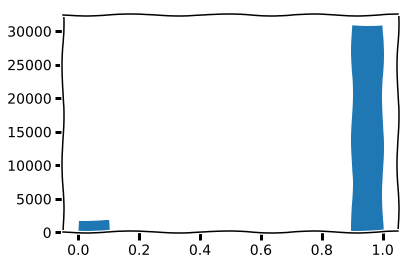

In [32]:
#first thing first, look at the data
plt.xkcd() #makes graphs look better
plt.hist(train['ACTION'])
plt.show()

It appears as if most predictions should be a 1. However, our first submission shows that the test set has many more zeroes than the train set.

Get rid of bad columns.

In [33]:
del train['ROLE_ROLLUP_1']
del train['ROLE_ROLLUP_2']
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,123472,117905,117906,290919,117908
1,1,17183,1540,123125,118536,118536,308574,118539
2,1,36724,14457,117884,117879,267952,19721,117880
3,1,36135,5396,119993,118321,240983,290919,118322
4,1,42680,5905,119569,119323,123932,19793,119325


In [34]:
del test['ROLE_ROLLUP_1']
del test['ROLE_ROLLUP_2']
test.head()

,id,RESOURCE,MGR_ID,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,117878,117879,118177,19721,117880
1,2,40644,4378,118507,118863,122008,118398,118865
2,3,75443,2395,119488,118172,301534,249618,118175
3,4,43219,19986,118403,120773,136187,118960,120774
4,5,42093,50015,119598,118422,300136,118424,118425


We will assume these new datasets are better bases for classification.

In [35]:
#From Paul Duan
def create_tuples(X):
    cols = []
    for i in range(X.shape[1]):
        for j in range(i, X.shape[1]):
            cols.append(X[:, i] + X[:, j]*3571)
    return np.hstack((X, np.vstack(cols).T))


def create_triples(X):
    cols = []
    for i in range(X.shape[1]):
        for j in range(i, X.shape[1]):
            for k in range(j, X.shape[1]):
                cols.append(X[:, i]*3461 + X[:, j]*5483 + X[:, k])
    return np.hstack((X, np.vstack(cols).T))

#mine
def onehot(x, y):
    enc = preprocessing.OneHotEncoder()
    enc.fit(np.vstack((x, y)))
    return enc.transform(x), enc.transform(y)

In [36]:
#try to make a tuple
tr_x = train.values[:, 1:]
tuple_x = create_tuples(np.vstack((tr_x, test.values[:, 1:])))

In [37]:
tuple_x.shape

(91690, 35)

In [38]:
tr_x.shape

(32769, 7)

In [39]:
tr_x = tuple_x[0:tr_x.shape[0], :]
te_x = tuple_x[tr_x.shape[0]:, :]
print tr_x.shape
print te_x.shape

(32769, 35)
(58921, 35)


In [40]:
#so we will use the smaller dataset
enc = sk.preprocessing.OneHotEncoder()
y = train.values[:, 0]
tr_x = train.values[:, 1:]
test_x = test.values[:, 1:]
enc.fit(np.vstack((tr_x, test_x)))
tr_x = enc.transform(tr_x)
test_x_fin = enc.transform(test_x)

In [41]:
#tuptrain_x = tuple_x[0:tr_x.shape[0], :]
#tuptest_x = tuple_x[tr_x.shape[0]:, :]

In [42]:
seed = 42
test_size = .20
#y_frame = train['ACTION']
#x_frame =train
#del x_frame['ACTION']
#x_frame = enc.transform(x_frame)
print type(tr_x)
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(tr_x, y, test_size=test_size, random_state=seed)
type(x_train)

<class 'scipy.sparse.csr.csr_matrix'>


scipy.sparse.csr.csr_matrix

In [43]:
#x_train = np.ndarray(x_train)
#print x_train
#x_train = np.hstack((x_train, (np.ones(x_train.shape[0], 1))))
#x_test = scp.hstack((x_test, scp.sparse.csr_matrix(np.ones(x_train.shape[0], 1))))
#x_test = np.ndarray(x_test)
#boosting
xgbmodel = xgb.XGBClassifier()
xgbmodel.fit(x_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [44]:
print x_train.shape
print x_test.shape
print y_train.shape


(26215, 16648)
(6554, 16648)
(26215,)


In [45]:
coo = x_test.tocoo(copy=False)
x_test_df = pd.DataFrame({'index':coo.row, 'col':coo.col, 'data':coo.data})[['index', 'col', 'data']].sort_values(['index', 'col']).reset_index(drop=True)
#print x_test1
x_train.shape

(26215, 16648)

In [46]:
xgb_preds = xgbmodel.predict(x_test)

In [47]:
xgb_preds.shape

(6554,)

Basically, XGBoost drops a few columns because they are all zeroes. This breaks the model. This sucks, as any model is basically useless without onehot encoding. Supposedly, the developers fixed this in the newest version. However, I could not install that version. (Trust me, I tried before I gave up and used pip, which stil took significant troubleshooting.) 


If this worked, I could generate a score using the returned xgb_preds and y_test values. (The score generation algorithm is available on kaggle.) Then I could manipulate the XGBoost model to try to get a better score, and submit my best scoring model. Unfortunatley, the developers of XGBoost had a different vision in mind when they built their software. A vision of hopelessness and despair.

So I reinstalled and now it works. Time to start boosting for real

In [48]:
#test accuracy
evaluate(xgb_preds, y_test)

0.50804924055707812

This is actually worse. Time to start playing with the model.

In [49]:
#smaller trees, less estimators
xgb2 = xgb.XGBClassifier(max_depth = 2, learning_rate = 0.5, n_estimators=50, silent=True)
xgb2.fit(x_train, y_train)
preds = xgb2.predict(x_test)
evaluate(y_test, preds)

0.87241748166259181

If this is correct, that is an insane jump.

In [50]:
#Let's try with stumps
xgb_stump = xgb.XGBClassifier(max_depth = 1, learning_rate= 0.5, n_estimators=50)
xgb_stump.fit(x_train, y_train)
preds = xgb_stump.predict(x_test)
print evaluate(y_test, preds)
print preds

0.90127785059
[1 1 1 ..., 1 1 1]


So this is really good. Like I don't believe it. Time to run Cross Validation.

In [51]:
#CV
import time
def cross_val(xgbs):
    start = time.time()
    expected_err = [0]*len(xgbs);
    expected_err_stump = 0;
    for i in range(0, 10):
        x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(tr_x, y, test_size=test_size, random_state=seed)
        for i in range(0, len(xgbs)):
            xgbs[i].fit(x_train, y_train)    #stump
            expected_err[i] += evaluate(xgbs[i].predict(x_test), y_test)
    for i in range(0, len(xgbs)):
        expected_err[i] = expected_err[i]/10
        print 'Model ', i, ": ", expected_err[i]
    run_time = time.time()-start
    print 'run time: ', int(run_time)/60,':',run_time%60, 's'
        
cross_val([xgb2, xgb_stump])

Model  0 :  0.510678426914
Model  1 :  0.516098481114
run time:  0 : 10.6450340748 s


As we can see, the previous 2 models got lucky when they presented us with high scores. In fact, they both suck.  Funny how the difference is so massive.

We also have a runtime. I will try the same code using the gpu plugin, to see if we get faster results.

In [52]:
params = {'max_depth':5, 'learning_rate':0.3, 'n_estimators':50, 'objective':'binary:logistic', 'updater':'grow_gpu'}
#xg_train = np.hstack([tr_x, y])
#label = xg_train.shape[1]-1
xgb_matrix = xgb.DMatrix(data=tr_x, label=y)
m1 = xgb.train(params=params, dtrain=xgb_matrix)
xt= xgb.DMatrix(data=x_test)
preds = m1.predict(xt, output_margin=False)
for i in range(0, len(preds)):
    if preds[i] > 0.5:
        preds[i]=1
    else:
        preds[i]=0
print evaluate(preds, y_test)
print preds

0.509404254107
[ 1.  1.  1. ...,  1.  1.  1.]


In [53]:
def transform(preds):
    for i in range(0, len(preds)):
        if preds[i] > 0.5:
            preds[i]=1
        else:
            preds[i]=0
    return preds

def cv(params, estimators):
    start = time.time()
    expected_err = [0]*len(params);
    expected_err_stump = 0;
    xgbs=[]
    for i in range(0, 10):
        print i*10, '% complete'
        x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(tr_x, y, test_size=test_size, random_state=seed)
        x_train = xgb.DMatrix(data=x_train, label=y_train)
        x_test = xgb.DMatrix(data=x_test)
        for i in range(0, len(params)):
            xgbs.append(xgb.train(params[i], dtrain=x_train, num_boost_round=estimators[i]))
            expected_err[i] += evaluate(transform(xgbs[i].predict(x_test)), y_test)
    for i in range(0, len(params)):
        expected_err[i] = expected_err[i]/10
        print 'Model ', i, ": ", expected_err[i]
    run_time = time.time()-start
    print 'run time: ', int(run_time)/60,'m',run_time%60, 's'

In [54]:
#params = {'max_depth':5, 'learning_rate':0.3, 'n_estimators':1000, 'objective':'binary:logistic', 'updater':'grow_gpu'}
#param2 = {'max_depth':1, 'learning_rate':0.3, 'n_estimators':1000, 'objective':'binary:logistic', 'updater':'grow_gpu'}
#models = [params, param2]
#estimators = [1000, 1000]
#cv(models, estimators)

In [55]:
#no gpu
#params = {'max_depth':5, 'learning_rate':0.3, 'n_estimators':1000, 'objective':'binary:logistic'}
#param2 = {'max_depth':1, 'learning_rate':0.3, 'n_estimators':1000, 'objective':'binary:logistic'}
#models = [params, param2]
#estimators = [1000, 1000]
#cv(models, estimators)

Apparently, GPU really slows down the models.

Stump is a little better, lets work with it.


In [56]:
xgb_stump50 = xgb.XGBClassifier(max_depth = 1, learning_rate=0.1, n_estimators=100)
xgb_stump100 = xgb.XGBClassifier(max_depth=1, learning_rate=0.5, n_estimators=50)
cross_val([xgb_stump50, xgb_stump100])

Model  0 :  0.5
Model  1 :  0.516098481114
run time:  0 : 12.8191699982 s


Samller learning rate and increased estimators both seem to do worse. 

In [57]:
xgb_s25 = xgb.XGBClassifier(max_depth=1, learning_rate=0.1, n_estimators=25)
xgb_s75 = xgb.XGBClassifier(max_depth=1, learning_rate=0.75, n_estimators=50)
cross_val([xgb_s25, xgb_s75])

Model  0 :  0.5
Model  1 :  0.534483506517
run time:  0 : 8.12539982796 s


So increased learning rate leads to better results.

In [58]:
xgb75 = xgb.XGBClassifier(max_depth = 3, learning_rate=0.75, n_estimators =50)
xgb75_25 = xgb.XGBClassifier(max_depth = 1, learning_rate=0.75, n_estimators=25)
cross_val([xgb75, xgb75_25])

Model  0 :  0.565325455195
Model  1 :  0.535515157092
run time:  0 : 8.99209594727 s


Increased max depth is really good. Let's try playing with the number of estimators.

In [59]:
xgb100 = xgb.XGBClassifier(max_depth = 3, learning_rate=0.75, n_estimators =100)
xgb5 = xgb.XGBClassifier(max_depth = 5, learning_rate=0.75, n_estimators =50)
cross_val([xgb100, xgb5])

Model  0 :  0.572970492033
Model  1 :  0.575680519133
run time:  0 : 16.2646460533 s


What happens at learning rate 1?

In [60]:
xgb1_3 = xgb.XGBClassifier(max_depth = 3, learning_rate=1, n_estimators =50)
xgb1_5 = xgb.XGBClassifier(max_depth = 5, learning_rate=1, n_estimators =50)
cross_val([xgb1_3, xgb1_5])

Model  0 :  0.578128744909
Model  1 :  0.593599779167
run time:  0 : 11.307612896 s


Allowing a higher max depth just gave a huge increase in performance when coupled with a higher learning rate. 

In [61]:
xgb100 = xgb.XGBClassifier(max_depth = 5, learning_rate=1, n_estimators=100)
xgb15 = xgb.XGBClassifier(max_depth=5, learning_rate=1.5, n_estimators=50)
cross_val([xgb100, xgb15])

Model  0 :  0.626343347508
Model  1 :  0.595139477668
run time:  0 : 17.580124855 s


In [62]:
xgb10 = xgb.XGBClassifier(max_depth = 10, learning_rate=1, n_estimators=100)
xgb200 = xgb.XGBClassifier(max_depth = 5, learning_rate=1, n_estimators=200)
cross_val([xgb10, xgb200])

Model  0 :  0.638700150947
Model  1 :  0.635585920128
run time:  0 : 38.0626480579 s


Increasing estimators, and depth of estimators worked wonders!!!
Eventually I will have to do more than guess at changes to the model...

In [64]:
xgb10 = xgb.XGBClassifier(max_depth = 10, learning_rate=1, n_estimators=200)
xgb200 = xgb.XGBClassifier(max_depth = 5, learning_rate=1, n_estimators=1000)
cross_val([xgb10, xgb200])

KeyboardInterrupt: 

Its incredible to me that these keep improving. But those last 2 models took at least 5 minutes to cross validate. Might as well go for gold though.

In [ ]:
xgb10_1000 = xgb.XGBClassifier(max_depth=10, learning_rate=1,n_estimators=1000)
cross_val([xgb10_1000])

It felt like this took 10 minutes to run, which is terribly disapointing for a 1% increase in accuracy. I have gone back and patched in a runtime counter.

In [ ]:
xgb15 = xgb.XGBClassifier(max_depth=15, learning_rate=1, n_estimators=100)
cross_val([xgb15])

So accuracy seems to increase with max depth and n_estimators, though runtime gets really bad if we increase these with reckless abandon. I will try one more run with max_depth=15 and n_estimators = 1000, but I expect minimal (if any) increase over 10/1000.

In [65]:
xgb15_1000 = xgb.XGBClassifier(max_depth=15, learning_rate=1, n_estimators=1000)
cross_val([xgb15_1000])

Model  0 :  0.69971804326
run time:  2 : 56.9792690277 s


In [ ]:
#xgb15_100_gpu = {'max_depth':15, 'learning_rate':1,'objective':'binary:logistic', 'updater':'grow_gpu'}
#cv([xgb15_100_gpu], [1000])

69%!!!! This jumped 1.5%, which was much more than I expected. Why stop bruteforcing? (Besides the runtime...)

In [ ]:
xgb15_1000.fit(tr_x, y)
final_preds = xgb15_1000.predict(test_x_fin)

In [ ]:
print final_preds.shape
print id.shape
print test_x_fin.shape
get_submission(final_preds, 'boosted_preds')

In [57]:
lgr = {'booster':'gblinear'}
estimators = [10, 50, 100, 500]
cv([lgr, lgr, lgr, lgr], estimators)

0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.64467053563
Model  1 :  0.662043189551
Model  2 :  0.667301562264
Model  3 :  0.665461504251
run time:  0 m 38.6918599606 s


Linear regressison models seem to be more accurate by default. Stacking estimators does not seem to help very much.

In [59]:
lgr = {'booster':'gblinear'}
estimators = [5, 10, 15, 20, 25, 50]
cv([lgr, lgr, lgr, lgr, lgr, lgr], estimators)

0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.635913007473
Model  1 :  0.64467053563
Model  2 :  0.651283921893
Model  3 :  0.6552681218
Model  4 :  0.657897308157
Model  5 :  0.662043189551
run time:  0 m 9.53281593323 s


We will stick with 50, as it seems to be the best tradeoff between speed and score.

Now lets add some weights to the model.

In [61]:
lgr ={}
lgr['booster'] = 'gblinear'
lgr['lambda'] = 0.1
cv([lgr], [50])

0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.652254010818
run time:  0 m 4.95634007454 s


In [87]:
cv_data = xgb.DMatrix(data=tr_x, label=y)
res = []
lambdas = []
for i in range(0, 10):
    lgr['lambda'] = float(i)/10
    lambdas.append(float(i)/10)
    res.append(xgb.cv(lgr, dtrain = cv_data, num_boost_round = 50, metrics={'error'}))

In [88]:
type(res[0])

pandas.core.frame.DataFrame

In [89]:
res[0].head()

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.063414,0.001144,0.022857,0.000265
1,0.061186,0.000799,0.019805,0.000413
2,0.062223,0.000653,0.018600,0.000078
3,0.062407,0.000604,0.017776,0.000238
4,0.062834,0.001142,0.017532,0.000336


In [90]:
testerr = []
trainerr = []
for df in res:
    testerr.append(df['test-error-mean'].mean(axis=0))
    trainerr.append(df['train-error-mean'].mean(axis=0))

In [91]:
print lambdaerr

[0.0631054, 0.06116763333333334, 0.059891933333333335, 0.05889103333333333, 0.05802443333333333, 0.057298133333333334, 0.056672466666666664, 0.05602240000000001, 0.05561346666666667, 0.055299266666666666]


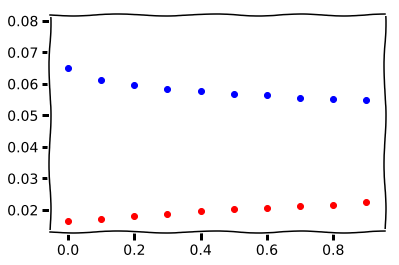

In [92]:
plt.scatter(lambdas, testerr, c='b')
plt.scatter(lambdas, trainerr, c='r')
plt.show()

It seems lambda will be 0.9

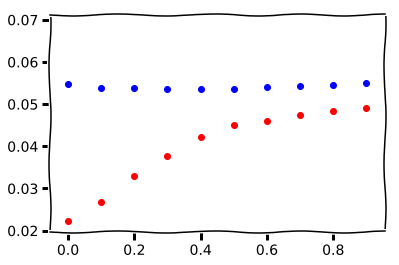

In [95]:
lgr['lambda'] = 0.9
lgr['alpha'] = 0
cv_data = xgb.DMatrix(data=tr_x, label=y)
res = []
alphas = []
for i in range(0, 10):
    lgr['alpha'] = float(i)/10
    alphas.append(float(i)/10)
    res.append(xgb.cv(lgr, dtrain = cv_data, num_boost_round = 50, metrics={'error'}))

testerr = []
trainerr = []
for df in res:
    testerr.append(df['test-error-mean'].mean(axis=0))
    trainerr.append(df['train-error-mean'].mean(axis=0))
    
plt.scatter(alphas, testerr, c='b')
plt.scatter(alphas, trainerr, c='r')
plt.show()

Test error remains constant, but it seems that training error increases with increase in alpha. I'll keep it at 0.3 for now.

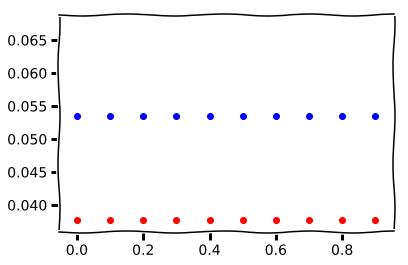

In [97]:
lgr['lambda'] = 0.9
lgr['alpha'] = 0.3
lgr['lambda_bias'] = 0
cv_data = xgb.DMatrix(data=tr_x, label=y)
res = []
lb = []
for i in range(0, 10):
    lgr['lambda_bias'] = float(i)/10
    lb.append(float(i)/10)
    res.append(xgb.cv(lgr, dtrain = cv_data, num_boost_round = 50, metrics={'error'}))

testerr = []
trainerr = []
for df in res:
    testerr.append(df['test-error-mean'].mean(axis=0))
    trainerr.append(df['train-error-mean'].mean(axis=0))
    
plt.scatter(lb, testerr, c='b')
plt.scatter(lb, trainerr, c='r')
plt.show()

This will just stay at 0.

In [120]:
class my_model():

    def __init__(self, gbl_params, gbt_params, ngbl, ngbt):
        self.lin = gbl_params
        self.tree = gbt_params
    
    def fit(self, x, y):
        data = xgb.DMatrix(data=x, label = y)
        self.m1 = xgb.train(self.lin, dtrain = data, num_boost_round = 50)
        preds = transform(self.m1.predict(xgb.DMatrix(data=x)))
        err = []
        for i in range(0, len(y)):
            if y[i] != preds[i]:
                err.append(1)
            else:
                err.append(0)
        data = xgb.DMatrix(data=x, label=err)
        self.m2 = xgb.train(self.tree, dtrain = data, num_boost_round=200)
        
    def predict(self, x):
        data = xgb.DMatrix(data=x)
        preds = transform(self.m1.predict(data))
        err = transform(self.m2.predict(data))
        preds = np.absolute(preds-err)
        return preds
        
        

In [100]:
lgr

{'alpha': 0.3,
 'aplha': 5.0,
 'booster': 'gblinear',
 'lambda': 0.9,
 'lambda_bias': 0.9}

In [102]:
lgr['lambda_bias']=0
cv([lgr], [50])

0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.591536478016
run time:  0 m 4.5983080864 s


In [103]:
for i in range(0, 10):
    lgr['lambda'] = float(i)/10
    cv([lgr], [50])

0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.609821383582
run time:  0 m 4.8096280098 s
0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.609113095981
run time:  0 m 4.90501499176 s
0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.608000604662
run time:  0 m 4.91266393661 s
0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.605856462768
run time:  0 m 4.76365709305 s
0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.600840612286
run time:  0 m 5.0142250061 s
0 % complete
10 %

In [105]:
gbl = {'booster':'gblinear'}
cv([gbt], [50])

0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.660607335257
run time:  0 m 4.91333413124 s


In [123]:
gbt = {'max_depth':15, 'learing_rate':1, 'objective':'binary:logistic'}
cv([gbt, gbl], [200, 50])

0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.632490968402
Model  1 :  0.661881508063
run time:  0 m 42.7306771278 s


In [121]:
lintree = my_model(gbl, gbt, 50, 200)

In [127]:
cross_val([lintree])

Model  0 :  0.664395961906
run time:  0 : 45.5462138653 s


Lol, it got worse...

In [128]:
#some more gpu tests
param = {'max_depth':3, 'learning_rate':0.3, 'objective':'binary:logistic', 'updater':'grow_gpu'}
param2 = {'max_depth':3, 'learning_rate':0.3, 'objective':'binary:logistic'}
cv([param], [50])
cv([param2], [50])

0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.507968399813
run time:  0 m 19.4526128769 s
0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
Model  0 :  0.507968399813
run time:  0 m 6.60225105286 s
